[View in Colaboratory](https://colab.research.google.com/github/keisuke6616/14-DBDA/blob/master/Section2_3.ipynb)

In [0]:
import numpy as np
import numpy.linalg as la

from scipy.stats import norm
import matplotlib.pyplot as plt

import time

# Section 2.3

We consider an example such as $\pi_i:N_p(\boldsymbol \mu_i, \boldsymbol \Sigma_i), \ i=1,2,$ having ${\boldsymbol \mu}_1 = {\bf 0}, {\boldsymbol \mu}_2 = (1, \ldots, 1, 0, \ldots, 0)^T$ whose first $\lceil tr({\bf \Sigma}_1^2) \rceil$ elements are 1.
Here ${\bf \Sigma}_1 = {\bf B} (0.3^{|i - j|^{1/3}}) {\bf B}$ and ${\bf \Sigma}_2 = 1.2 {\bf B} (0.3^{|i - j|^{1/3}}) {\bf B}$, where ${\bf B} = diag[{0.5 + 1 / (p + 1)}^{1/2}, \ldots, {0.5 + p / (p + 1)}^{1/2}]$ 

We set $(n_1, n_2) = (\log_2p, 2log_2p)$. Note that $\Delta = ||\boldsymbol \mu_1 - \boldsymbol \mu_2||^2, \ \delta_i = \left\{ \frac{tr(\boldsymbol \Sigma_i^2)}{n_i} + \frac{tr(\boldsymbol \Sigma_1 \boldsymbol \Sigma_2)}{n_{i'}} + \frac{tr(\Sigma_1^2)}{2n_1(n_1-1)} + \frac{tr(\Sigma_2^2)}{2n_2(n_2-1)} \right\}^{1/2}$ for $i (\neq i') = 1, 2$

We considered case of $p = 2^s, s = 3, \ldots, 14$. Independent pseudorandom 2000 observations of $w({\bf x_0}|n_1, n_2)$ were generated when ${\bf x_0} \in \pi_1$ or $\pi_2$

## Figure 4

In [2]:
np.random.seed(0)
t1 = time.time()

c = [1, 1.2]
N_class = 2
N_dim = 12
iter = 2000
result = np.zeros((N_dim, N_class))
line = np.zeros((N_dim, N_class))

for s in range(N_dim):
    p = 2**(s + 3)
    print('Dimension:{}'.format(p))
    print('Calculating...')
  
    n = [int(np.log2(p)), int(2 * np.log2(p))]

    #create Sigma
    Sigma, P, Q = [], [], []
    S = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            S[i, j] = (1/2 + (i+1) / (p+1))**(1/2) * 0.3**(np.abs(i - j)**(1/3)) * (1/2 + (j + 1) / (p + 1))**(1/2)
        
    for i in range(N_class):
        Sigma.append(c[i] * S)
        value, vec = la.eig(Sigma[i])
        P.append(np.sqrt(value)); Q.append(vec.T)
    
    #create mu
    mu = []
    N_one = int(np.ceil(np.trace(np.dot(Sigma[0], Sigma[0]))**(1/2)))
    mu.append(np.zeros(p))
    mu.append(np.r_[np.ones(N_one), np.zeros(p - N_one)]) 
  
    #create delta and Delta
    Delta = la.norm(mu[0] - mu[1])**2  
    delta = []
    for i in range(N_class):
        delta.append((np.trace(np.dot(Sigma[i], Sigma[i])) / n[i] + np.trace(np.dot(Sigma[i], Sigma[-(i+1)])) / n[-(i+1)] \
                     + np.trace(np.dot(Sigma[0], Sigma[0])) / (2 * n[0] * (n[0] - 1)) + np.trace(np.dot(Sigma[1], Sigma[1])) / (2 * n[1] * (n[1] - 1)))**(1/2))
    
        line[s, i] = norm.cdf(- Delta / (2 * delta[i]), loc=0, scale=1)

    
    
    for l in range(iter):
        mean, trS =[], []
        x = []
        for i in range(N_class):
            Z = np.array([P[i] * np.random.normal(0, 1, p) for j in range(n[i])])
            X = np.dot(Z, Q[i]) + mu[i]
            cov = np.cov(X, rowvar=False)

            mean.append(np.mean(X, axis=0))
            trS.append(np.trace(cov))

            # creat new data
            z = P[i] * np.random.normal(0, 1, p)
            x.append(np.dot(z, Q[i]) + mu[i])


        # DBDA
        for i in range(N_class):
            classifier = np.dot(x[i] - (mean[0] + mean[1]) / 2, mean[1] - mean[0]) - trS[0] / (2 * n[0]) + trS[1] / (2 * n[1])
            if (-1)**i * classifier < 0:
                result[s, i] += 1
        
        
    print('Result')
    print('(class1, class2) = ({}, {})'.format(result[s, 0], result[s, 1]))
    print('Finished')
    print('')


t2 = time.time() - t1
print('Calculation time:{: .3f}'.format(t2))


Dimension:8
Calculating...
Result
(class1, class2) = (1430.0, 1368.0)
Finished

Dimension:16
Calculating...
Result
(class1, class2) = (1455.0, 1426.0)
Finished

Dimension:32
Calculating...
Result
(class1, class2) = (1538.0, 1472.0)
Finished

Dimension:64
Calculating...
Result
(class1, class2) = (1569.0, 1512.0)
Finished

Dimension:128
Calculating...
Result
(class1, class2) = (1651.0, 1570.0)
Finished

Dimension:256
Calculating...
Result
(class1, class2) = (1607.0, 1587.0)
Finished

Dimension:512
Calculating...
Result
(class1, class2) = (1673.0, 1627.0)
Finished

Dimension:1024
Calculating...
Result
(class1, class2) = (1713.0, 1661.0)
Finished

Dimension:2048
Calculating...


KeyboardInterrupt: ignored

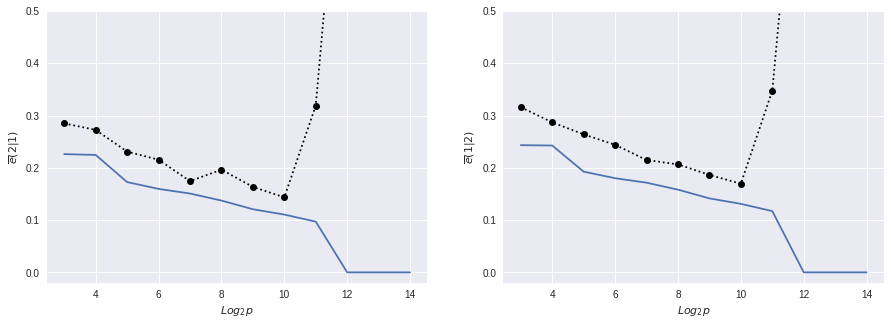

In [3]:
error = np.zeros((2, N_dim))
for i in range(N_dim):
    error[0, i] = 1 - result[i, 0] / iter
    error[1, i] = 1 - result[i, 1] / iter
    
pl = np.arange(3, 15, 1)
ylabel_list = ['$\overline{e}(2|1)$', '$\overline{e}(1|2)$']

plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(pl, error[i], 'o:', color='black')
    plt.plot(pl, line.T[i])
    plt.ylim(-0.02, 0.5)
    plt.ylabel(ylabel_list[i])
    plt.xlabel('$Log_2p$')


## Figure 5

In [0]:
np.random.seed(0)
t1 = time.time()

c = [1, 1.2]
N_class = 2
dim = [32, 1024]
N_dim = len(dim)
index = [0, 1]
iter = 2000
result = np.zeros((N_dim,  N_class, iter))
Delta = np.zeros(N_dim)
delta = np.zeros((N_dim, N_class))

for p, pc in zip(dim, index):
    print('Dimension:{}'.format(p))
    print('Calculating...')
  
    n = [int(np.log2(p)), int(2 * np.log2(p))]

    #create Sigma
    Sigma, P, Q = [], [], []
    S = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            S[i, j] = (1/2 + (i+1) / (p+1))**(1/2) * 0.3**(np.abs(i - j)**(1/3)) * (1/2 + (j + 1) / (p + 1))**(1/2)
      
    for i in range(N_class):
        Sigma.append(c[i] * S)
        value, vec = la.eig(Sigma[i])
        P.append(np.sqrt(value)); Q.append(vec.T)
    
    #create mu
    mu = []
    N_one = int(np.ceil(np.trace(np.dot(Sigma[0], Sigma[0]))**(1/2)))
    mu.append(np.zeros(p))
    mu.append(np.r_[np.ones(N_one), np.zeros(p - N_one)]) 
  
    #create delta and Delta
    Delta[pc] = la.norm(mu[0] - mu[1])**2  
    for i in range(N_class):
        delta[pc, i] = (np.trace(np.dot(Sigma[i], Sigma[i])) / n[i] + np.trace(np.dot(Sigma[i], Sigma[-(i+1)])) / n[-(i+1)] \
                     + np.trace(np.dot(Sigma[0], Sigma[0])) / (2 * n[0] * (n[0] - 1)) + np.trace(np.dot(Sigma[1], Sigma[1])) / (2 * n[1] * (n[1] - 1)))**(1/2)

  
  
    for l in range(iter):
        mean, trS =[], []
        x = []
        for i in range(N_class):
            Z = np.array([P[i] * np.random.normal(0, 1, p) for j in range(n[i])])
            X = np.dot(Z, Q[i]) + mu[i]
            cov = np.cov(X, rowvar=False)

            mean.append(np.mean(X, axis=0))
            trS.append(np.trace(cov))

            # creat new data
            z = P[i] * np.random.normal(0, 1, p)
            x.append(np.dot(z, Q[i]) + mu[i])


        # DBDA
        for i in range(N_class):
            result[pc, i, l] = np.dot(x[i] - (mean[0] + mean[1]) / 2, mean[1] - mean[0]) - trS[0] / (2 * n[0]) + trS[1] / (2 * n[1])
        
    print('Finished')
    print('')


t2 = time.time() - t1
print('Calculation time:{: .3f}'.format(t2))


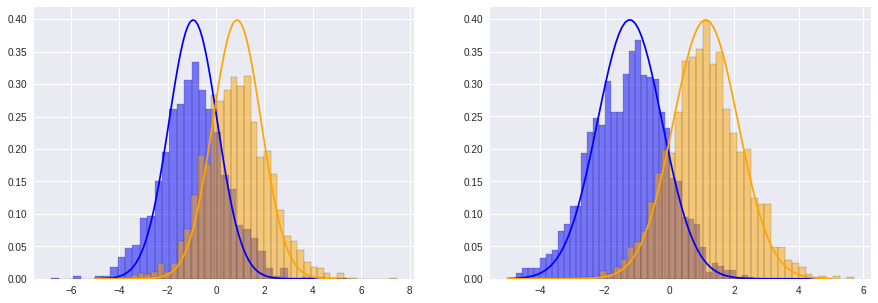

In [99]:
x = np.linspace(-5, 5, 100)

plt.figure(figsize=(15, 5))
color_list = ['blue', 'orange']

for i in range(2):
    PDF = []
    plt.subplot(1, 2, i+1)
    for j in range(2):
        PDF.append(norm.pdf(x, loc=(-1)**(j+1) * Delta[i]/(2*delta[i, j]), scale=1)) 
  
        plt.plot(x, PDF[j], color=color_list[j])
        plt.hist(result[i, j] / delta[i, j], bins=40, color=color_list[j], alpha=.5, normed=True, ec='black')
  
  

